## 1 加载数据

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

In [2]:
data_raw = pd.read_parquet("vhrdata").drop_duplicates(subset=None, keep='last', inplace=False)
drop_columns = ["ebs_Q_Charge", "ebs_Q_Discharge", "BCM_ebs_I_BATT", "dcdc_OverTemperature", "IC_LowBatteryvoltage",
                "DCDC_realInputVoltage", "DCDC_realInputCurrent"]
data_raw = data_raw.drop(columns=drop_columns)
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3207576 entries, 0 to 3207575
Data columns (total 46 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   vin                       object 
 1   collect_ts                int64  
 2   uuid                      object 
 3   model_name                object 
 4   series_code               object 
 5   msg_create_time           object 
 6   vcu_VehicleMode           float32
 7   vcu_vehicleSpeed          float32
 8   VCU_VehicleSpeedValid     float32
 9   vcu_state                 float32
 10  bms_SOC                   float32
 11  bms_state                 float32
 12  BCM_ebs_U_BATT            float32
 13  BCM_ebs_SOC               float32
 14  BCM_ebs_SOH_SUL           float32
 15  BCM_ebs_SOC_STATE         float32
 16  BCM_ebs_SOH_SUL_STATE     float32
 17  bcm_12VBatterySOC         float32
 18  dcdc_realOutputVoltage    float32
 19  dcdc_realOutputCurrent    float32
 20  DCDC_AlerState          

## 2 蓄电池电压和dcdc关系

In [ ]:
print(data_raw["bcm_HvOnRequest"].describe())
print(data_raw["bcm_HvOffRequest"].describe())

In [ ]:
a1 = data_raw[(data_raw.BCM_ebs_U_BATT > 0) & (data_raw.BCM_ebs_U_BATT <= 10.5)].size
b1 = data_raw[(data_raw.BCM_ebs_U_BATT > 0) & (data_raw.BCM_ebs_U_BATT <= 10.5)
              & (data_raw.dcdc_realOutputVoltage <= 10.5) & (data_raw.dcdc_realOutputVoltage > 0)
              #& (data_raw.vcu_dcdc_enable == 0)
              ].size
print(a1, b1, b1 / a1)

In [ ]:
attributes = ["BCM_ebs_U_BATT", "dcdc_realOutputVoltage"]
scatter_matrix(data_raw[(data_raw.BCM_ebs_U_BATT > 0) & (data_raw.BCM_ebs_U_BATT <= 10.5)][attributes], figsize=(8, 8))

1. ebs_Q_Charge ebs_Q_Discharge BCM_ebs_I_BATT  dcdc_OverTemperature 一直为 0.0，同时又不是状态值，直接删除这些特征
2. IC_LowBatteryvoltage  DCDC_realInputVoltage  DCDC_realInputCurrent 全为空，直接删除这些特征
3. DCDC_MCU_HVIL_Warning DCDC_BMS_HVIL_Warning DCDC_HV_InterlockStatus1 DCDC_HV_InterlockStatus dcdc_deratingStatus 作为状态值先保留
4. BCM_ebs_U_BATT 中间存在 3.0 的值将这部分提取出来进一步观察

In [ ]:
attributes = ["BCM_ebs_U_BATT", "dcdc_realOutputVoltage"]
scatter_matrix(data_raw[(data_raw.BCM_ebs_U_BATT < 14.5) & (data_raw.BCM_ebs_U_BATT > 10.5)][attributes], figsize=(8, 8))

## 3 故障车辆

LM8F7D99XNA019581,91
LM8F7D891NA000192,50
LM8F7D791NA047269,48
LM8F7D798NA045423,46
LM8F7D89XMA008192,44
LM8F7D896NA007722,43
LM8F7D893NA002400,31
LM8F7D797NA030721,30
LM8F7D897NA000312,23
LM8F7D795NA038249,15
LM8F7D797MAS00719,13
LM8F7D895NA002236,12
LM8F7D895NA003368,9
LM8F7D898NA003168,9
LM8F7D896NA001211,8
LM8F7D893NA000825,7
LM8F7D992NA036889,6
LM8F7D992NA056382,6
LM8F7D897NA000147,6
LM8F7D892NA001321,5
LM8F7D999NA042740,4
LM8F7D997MAS00619,4
LM8F7D899NA000800,2
LM8F7D892NA000976,2
LM8F7D792NA012370,2
LM8F7D991NA025057,2

In [ ]:
data_raw[(data_raw.BCM_ebs_U_BATT > 0) & (data_raw.BCM_ebs_U_BATT <= 10.5)]["vin"].value_counts()

## 4 LM8F7D99XNA019581 dc-dc 故障
DCDC_AlerState 三级故障
疑问：此时的 dc-dc 的输出电压为何会远远小于蓄电池的电压

In [5]:
data19581= data_raw[data_raw.vin == 'LM8F7D99XNA019581'].fillna(method='bfill').sort_values(by="collect_ts")
data19581 = data19581[(data19581["BCM_ebs_U_BATT"] > 3.) & (data19581["BCM_ebs_U_BATT"] < 18.)]
data19581.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13689 entries, 752219 to 2517964
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   vin                       13689 non-null  object 
 1   collect_ts                13689 non-null  int64  
 2   uuid                      13689 non-null  object 
 3   model_name                13689 non-null  object 
 4   series_code               13689 non-null  object 
 5   msg_create_time           13689 non-null  object 
 6   vcu_VehicleMode           13689 non-null  float32
 7   vcu_vehicleSpeed          13689 non-null  float32
 8   VCU_VehicleSpeedValid     13689 non-null  float32
 9   vcu_state                 13689 non-null  float32
 10  bms_SOC                   13689 non-null  float32
 11  bms_state                 13689 non-null  float32
 12  BCM_ebs_U_BATT            13689 non-null  float32
 13  BCM_ebs_SOC               13689 non-null  float32
 14  BCM_

In [6]:
data19581_copy = data19581.copy()
data19581_copy['date'] = pd.to_datetime(data19581_copy["collect_ts"], unit='ms')
data19581_copy = data19581_copy.set_index("date")

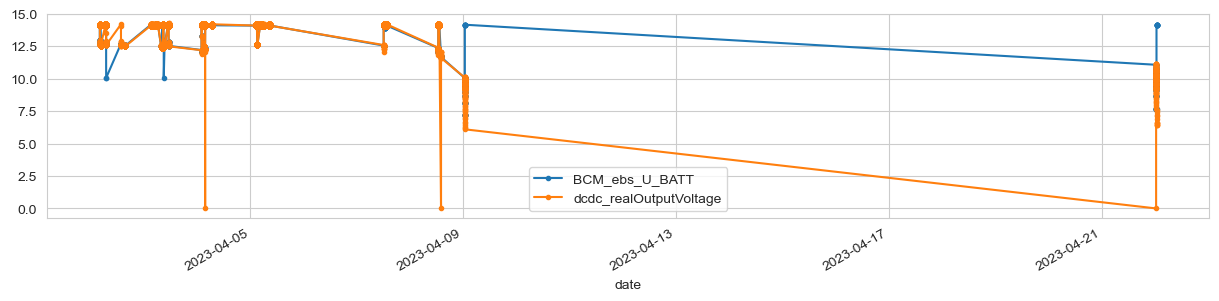

In [8]:
import matplotlib.pyplot as plt

data19581_copy["2023-04-02 00:00:00":"2023-04-24 22:00:00"][["BCM_ebs_U_BATT", "dcdc_realOutputVoltage"]].plot(grid=True, marker=".", figsize=(15, 3))
# extra code – saves the figure for the book
plt.show()

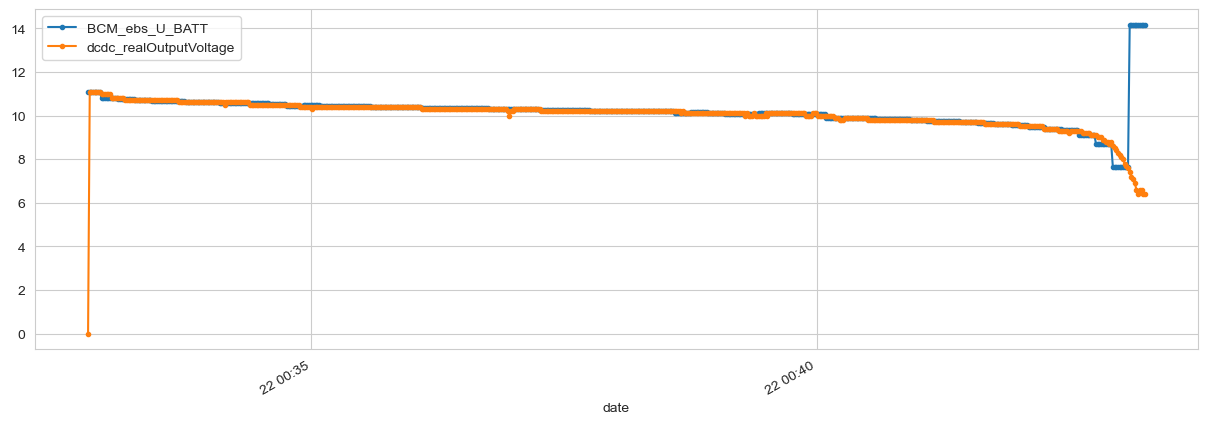

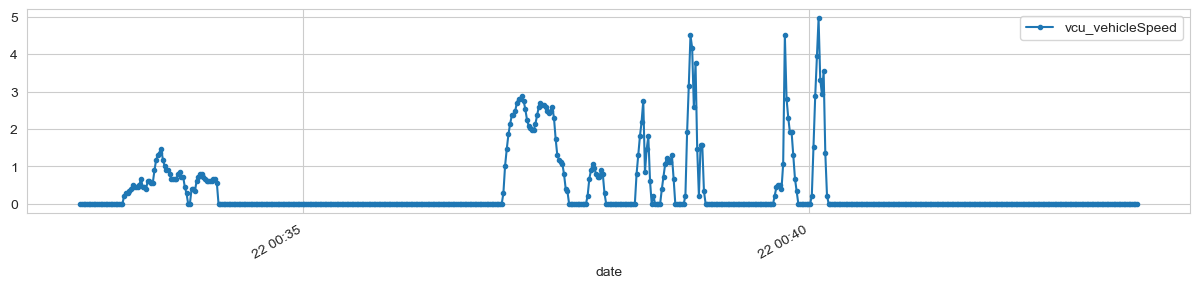

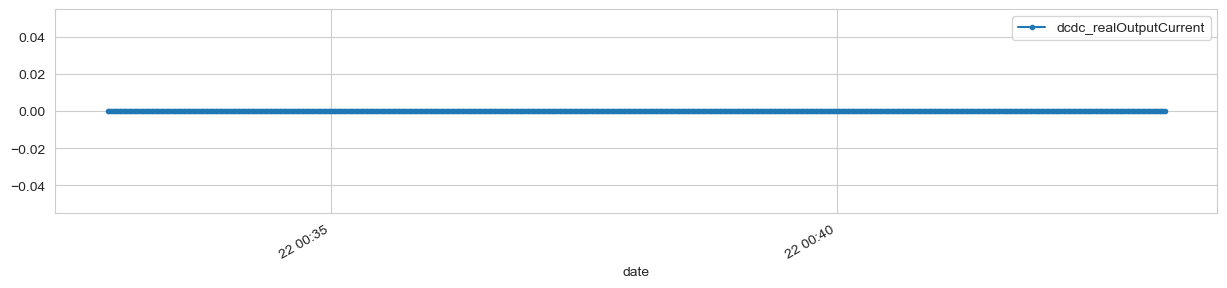

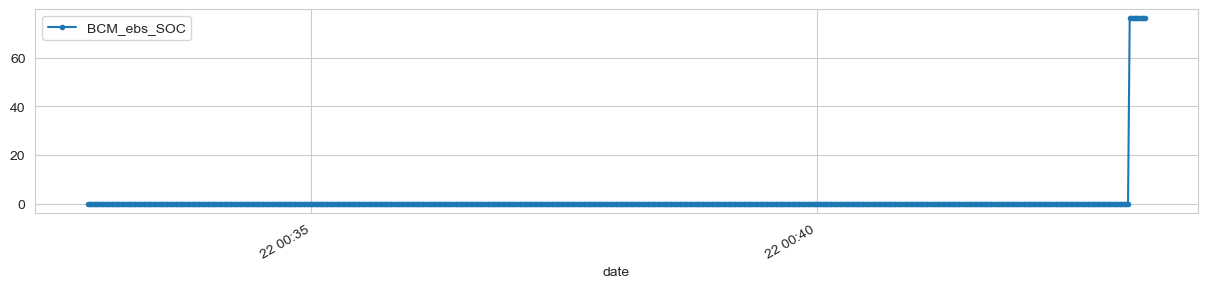

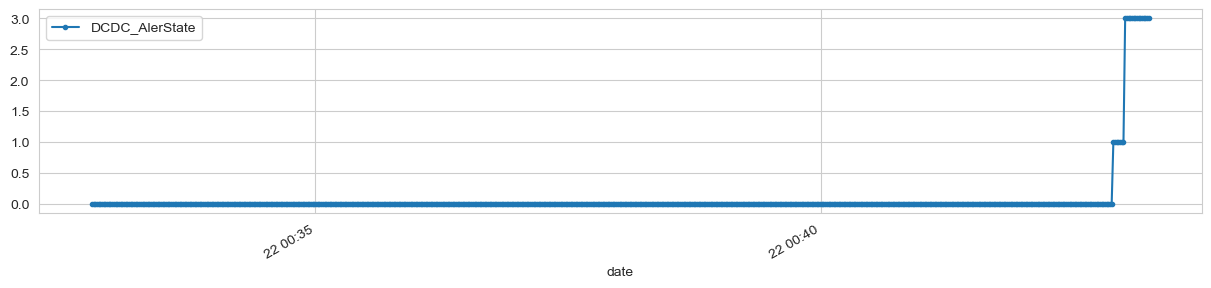

In [33]:

data19581_copy["2023-04-22 00:00:00":"2023-04-26 09:10:00"][["BCM_ebs_U_BATT", "dcdc_realOutputVoltage"]].plot(grid=True, marker=".", figsize=(15, 5))

data19581_copy["2023-04-22 00:00:00":"2023-04-26 09:10:00"][["vcu_vehicleSpeed"]].plot(grid=True, marker=".", figsize=(15, 3))
data19581_copy["2023-04-22 00:00:00":"2023-04-26 09:10:00"][["dcdc_realOutputCurrent"]].plot(grid=True, marker=".", figsize=(15, 3))
data19581_copy["2023-04-22 00:00:00":"2023-04-26 09:10:00"][["BCM_ebs_SOC"]].plot(grid=True, marker=".", figsize=(15, 3))
data19581_copy["2023-04-22 00:00:00":"2023-04-26 09:10:00"][["DCDC_AlerState"]].plot(grid=True, marker=".", figsize=(15, 3))

# extra code – saves the figure for the book
plt.show()

## 5 LM8F7D891NA000192 BMS_SOC==0
原因 BMS soc 为0 ,造成 dc-dc 没有输出,
疑问：为何该车的 bms 一直很低？

In [17]:
data00192= data_raw[data_raw.vin == 'LM8F7D891NA000192'].fillna(method='bfill').sort_values(by="collect_ts")
data00192 = data00192[(data00192["BCM_ebs_U_BATT"] > 3.) & (data00192["BCM_ebs_U_BATT"] < 18.)]

<class 'pandas.core.frame.DataFrame'>
Index: 75670 entries, 2138304 to 1080228
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   vin                       75670 non-null  object 
 1   collect_ts                75670 non-null  int64  
 2   uuid                      75670 non-null  object 
 3   model_name                75670 non-null  object 
 4   series_code               75670 non-null  object 
 5   msg_create_time           75670 non-null  object 
 6   vcu_VehicleMode           75670 non-null  float32
 7   vcu_vehicleSpeed          75670 non-null  float32
 8   VCU_VehicleSpeedValid     75670 non-null  float32
 9   vcu_state                 75670 non-null  float32
 10  bms_SOC                   75670 non-null  float32
 11  bms_state                 75670 non-null  float32
 12  BCM_ebs_U_BATT            75670 non-null  float32
 13  BCM_ebs_SOC               75670 non-null  float32
 14  BCM

In [19]:
data00192_copy = data00192.copy()
data00192_copy['date'] = pd.to_datetime(data00192_copy["collect_ts"], unit='ms')
data00192_copy = data00192_copy.set_index("date")

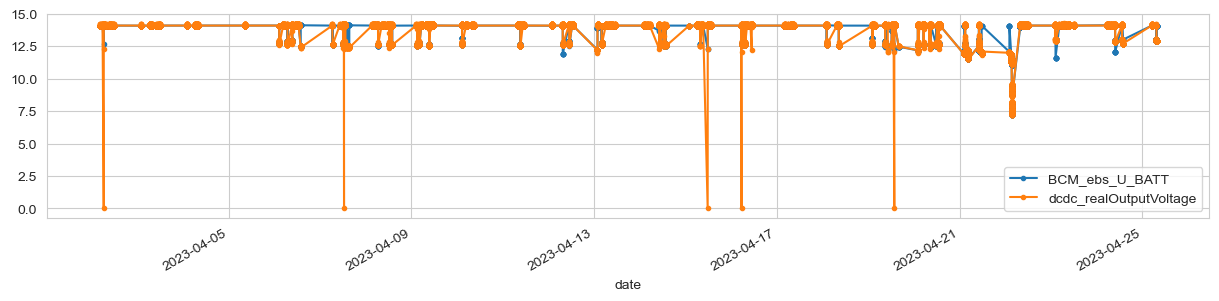

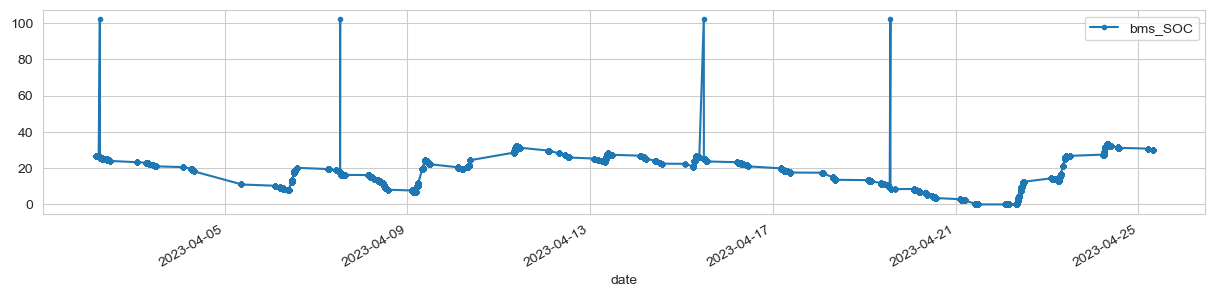

In [30]:
data00192_copy["2023-04-02 00:00:00":"2023-04-26 22:00:00"][["BCM_ebs_U_BATT", "dcdc_realOutputVoltage"]].plot(grid=True, marker=".", figsize=(15, 3))
data00192_copy["2023-04-02 00:00:00":"2023-04-26 22:00:00"][["bms_SOC"]].plot(grid=True, marker=".", figsize=(15, 3))
# extra code – saves the figure for the book
plt.show()

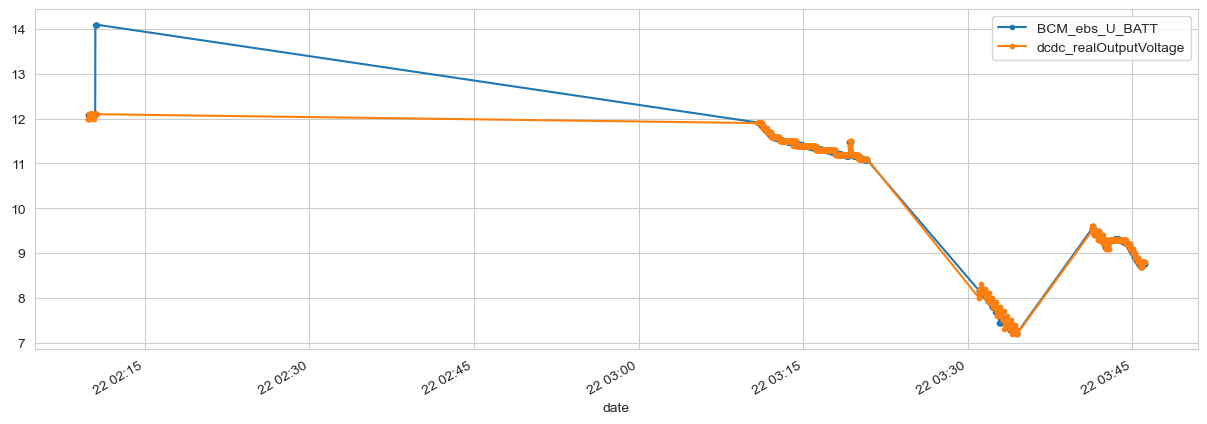

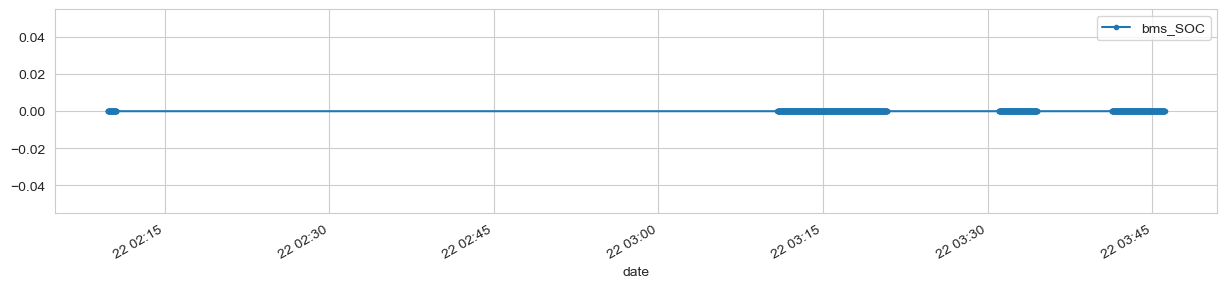

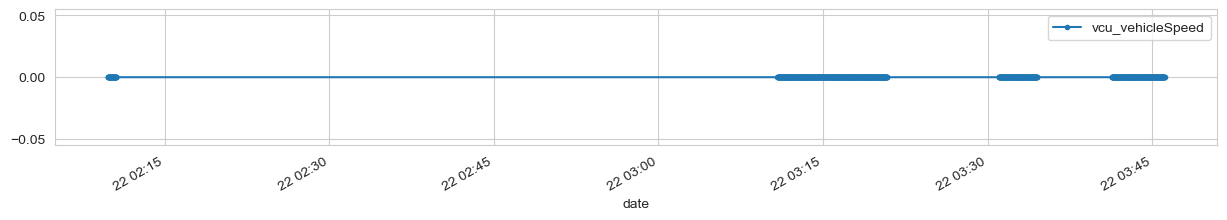

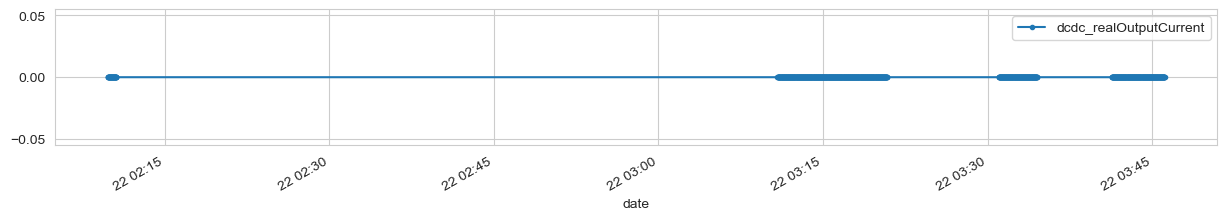

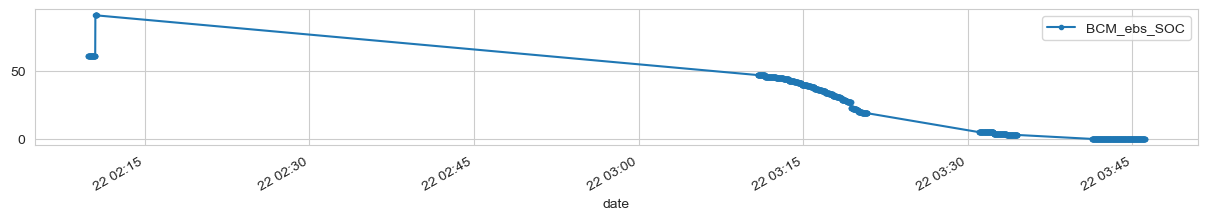

In [28]:
data00192_copy["2023-04-22 01:00:00":"2023-04-22 04:00:00"][["BCM_ebs_U_BATT", "dcdc_realOutputVoltage"]].plot(grid=True, marker=".", figsize=(15, 5))
data00192_copy["2023-04-22 01:00:00":"2023-04-22 04:00:00"][["bms_SOC"]].plot(grid=True, marker=".", figsize=(15, 3))
data00192_copy["2023-04-22 01:00:00":"2023-04-22 04:00:00"][["vcu_vehicleSpeed"]].plot(grid=True, marker=".", figsize=(15, 2))
data00192_copy["2023-04-22 01:00:00":"2023-04-22 04:00:00"][["dcdc_realOutputCurrent"]].plot(grid=True, marker=".", figsize=(15, 2))
data00192_copy["2023-04-22 01:00:00":"2023-04-22 04:00:00"][["BCM_ebs_SOC"]].plot(grid=True, marker=".", figsize=(15, 2))

plt.show()

## 6 LM8F7D791NA047269 dc-dc 故障

In [40]:
data47269= data_raw[data_raw.vin == 'LM8F7D791NA047269'].fillna(method='bfill').sort_values(by="collect_ts")
data47269 = data47269[(data47269["BCM_ebs_U_BATT"] > 3.) & (data47269["BCM_ebs_U_BATT"] < 18.)]
data47269_copy = data47269.copy()
data47269_copy['date'] = pd.to_datetime(data47269_copy["collect_ts"], unit='ms')
data47269_copy = data47269_copy.set_index("date")

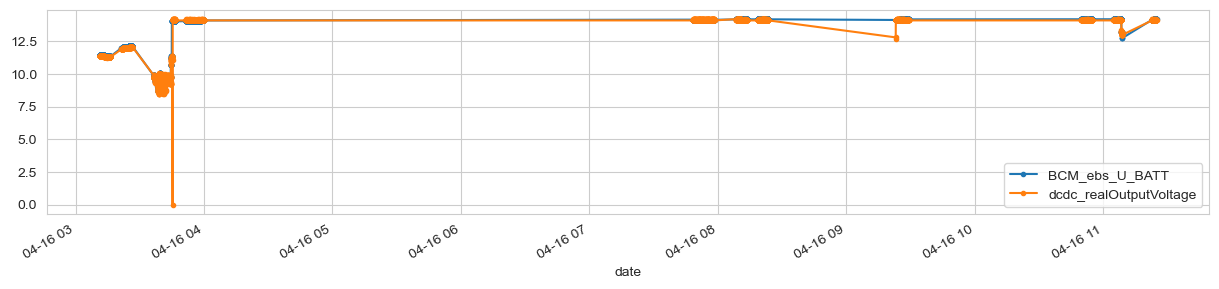

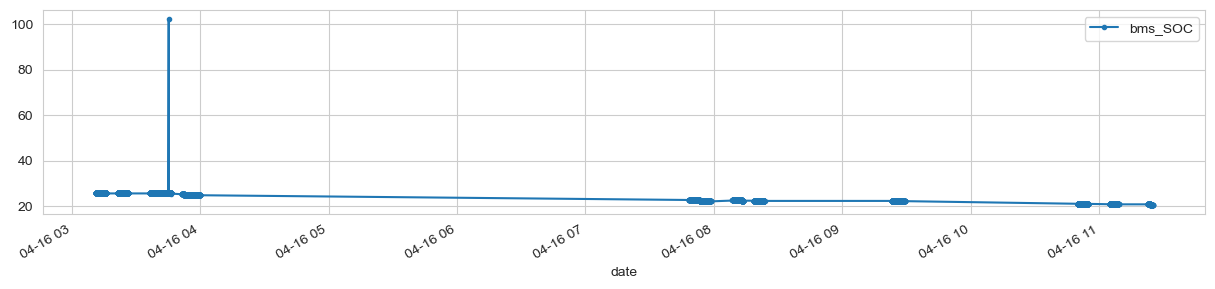

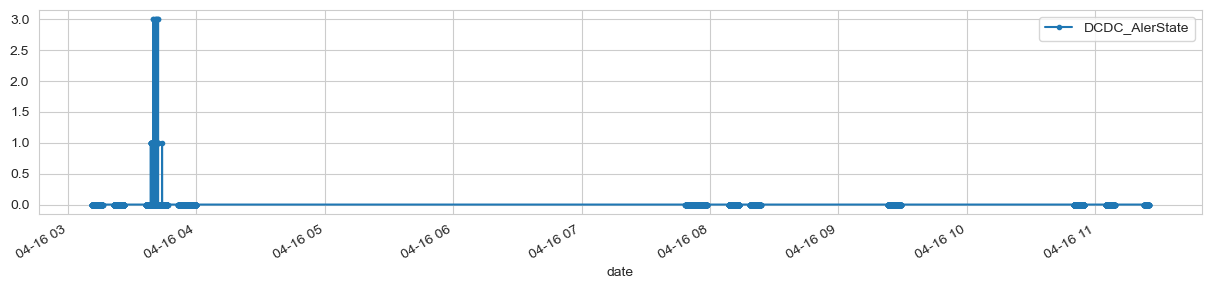

In [44]:
data47269_copy["2023-04-16 00:00:00":"2023-04-16 22:00:00"][["BCM_ebs_U_BATT", "dcdc_realOutputVoltage"]].plot(grid=True, marker=".", figsize=(15, 3))
data47269_copy["2023-04-16 00:00:00":"2023-04-16 22:00:00"][["bms_SOC"]].plot(grid=True, marker=".", figsize=(15, 3))
data47269_copy["2023-04-16 00:00:00":"2023-04-16 22:00:00"][["DCDC_AlerState"]].plot(grid=True, marker=".", figsize=(15, 3))
# extra code – saves the figure for the book
plt.show()

## 7 LM8F7D798NA045423 dc-dc 故障

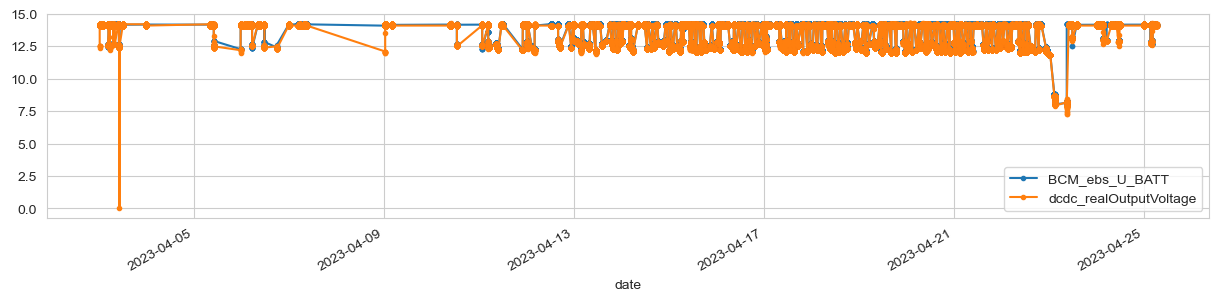

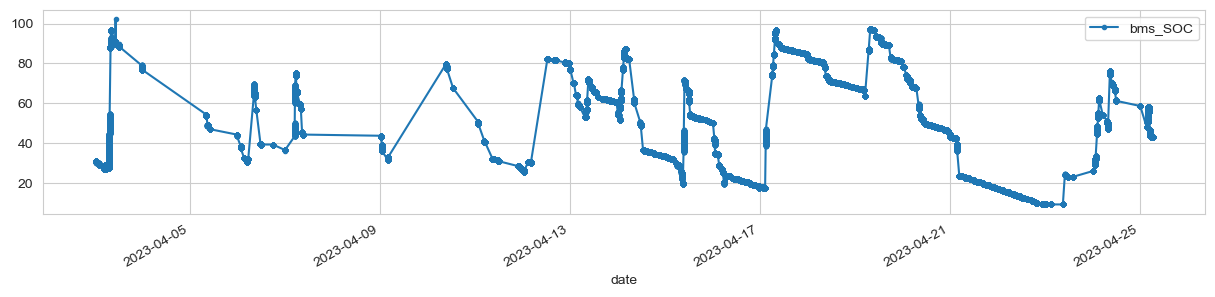

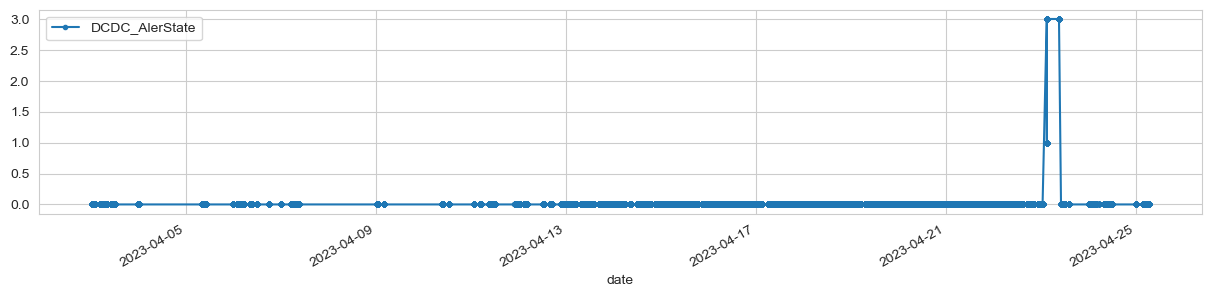

In [46]:
data45423= data_raw[data_raw.vin == 'LM8F7D798NA045423'].fillna(method='bfill').sort_values(by="collect_ts")
data45423 = data45423[(data45423["BCM_ebs_U_BATT"] > 3.) & (data45423["BCM_ebs_U_BATT"] < 18.)]
data45423_copy = data45423.copy()
data45423_copy['date'] = pd.to_datetime(data45423_copy["collect_ts"], unit='ms')
data45423_copy = data45423_copy.set_index("date")
data45423_copy["2023-04-02 00:00:00":"2023-04-26 22:00:00"][["BCM_ebs_U_BATT", "dcdc_realOutputVoltage"]].plot(grid=True, marker=".", figsize=(15, 3))
data45423_copy["2023-04-02 00:00:00":"2023-04-26 22:00:00"][["bms_SOC"]].plot(grid=True, marker=".", figsize=(15, 3))
data45423_copy["2023-04-02 00:00:00":"2023-04-26 22:00:00"][["DCDC_AlerState"]].plot(grid=True, marker=".", figsize=(15, 3))
# extra code – saves the figure for the book
plt.show()

## 8 LM8F7D89XMA008192 dc-dc 故障

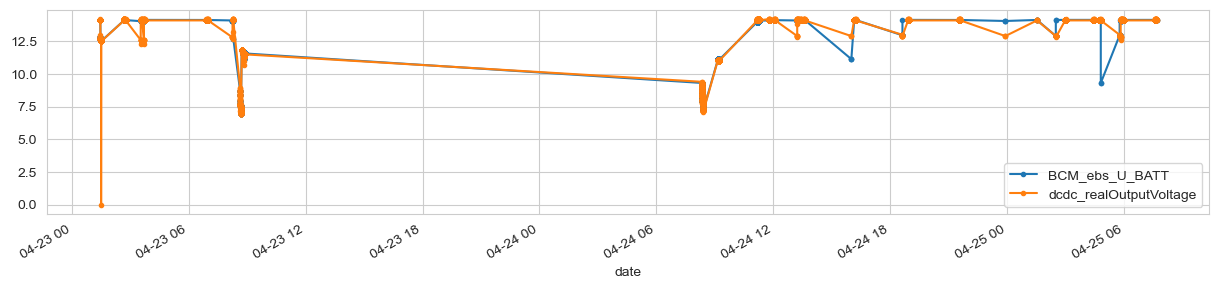

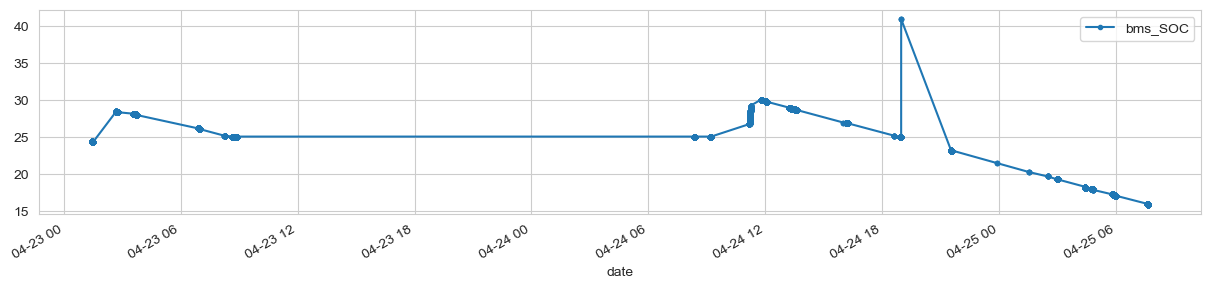

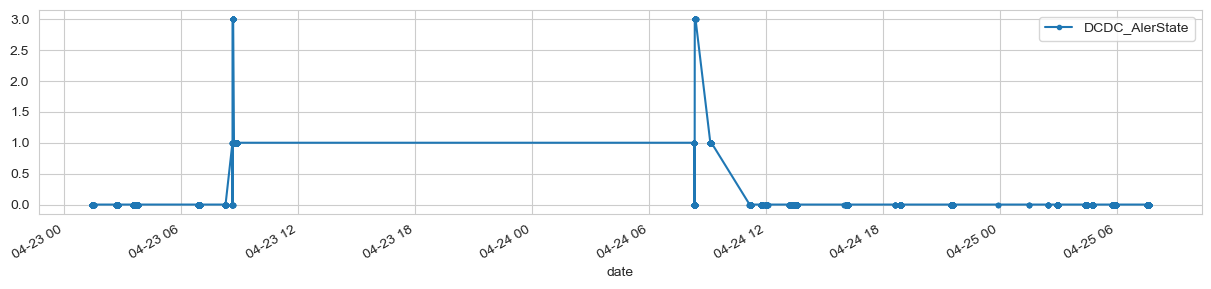

In [48]:
data08192= data_raw[data_raw.vin == 'LM8F7D89XMA008192'].fillna(method='bfill').sort_values(by="collect_ts")
data08192 = data08192[(data08192["BCM_ebs_U_BATT"] > 3.) & (data08192["BCM_ebs_U_BATT"] < 18.)]
data08192_copy = data08192.copy()
data08192_copy['date'] = pd.to_datetime(data08192_copy["collect_ts"], unit='ms')
data08192_copy = data08192_copy.set_index("date")
data08192_copy["2023-04-23 00:00:00":"2023-04-26 22:00:00"][["BCM_ebs_U_BATT", "dcdc_realOutputVoltage"]].plot(grid=True, marker=".", figsize=(15, 3))
data08192_copy["2023-04-23 00:00:00":"2023-04-26 22:00:00"][["bms_SOC"]].plot(grid=True, marker=".", figsize=(15, 3))
data08192_copy["2023-04-23 00:00:00":"2023-04-26 22:00:00"][["DCDC_AlerState"]].plot(grid=True, marker=".", figsize=(15, 3))
# extra code – saves the figure for the book
plt.show()

## 9 LM8F7D896NA007722 dc-dc故障 叠加 soc 低

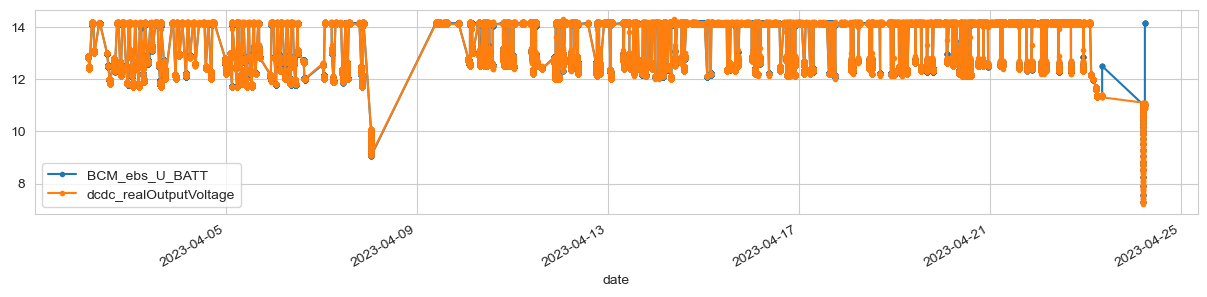

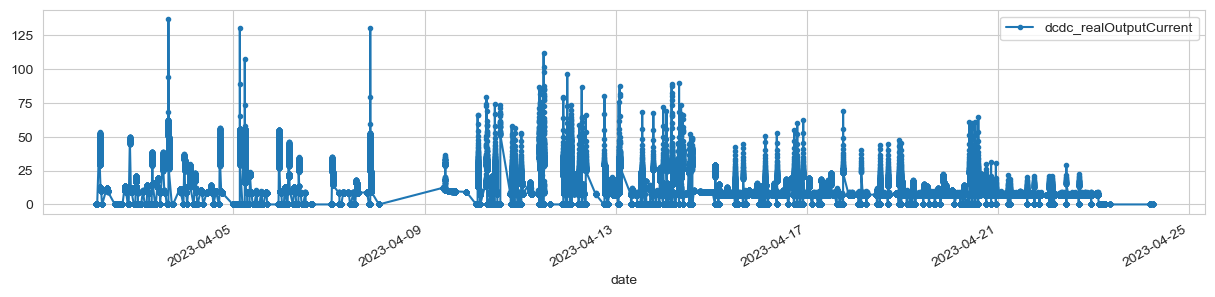

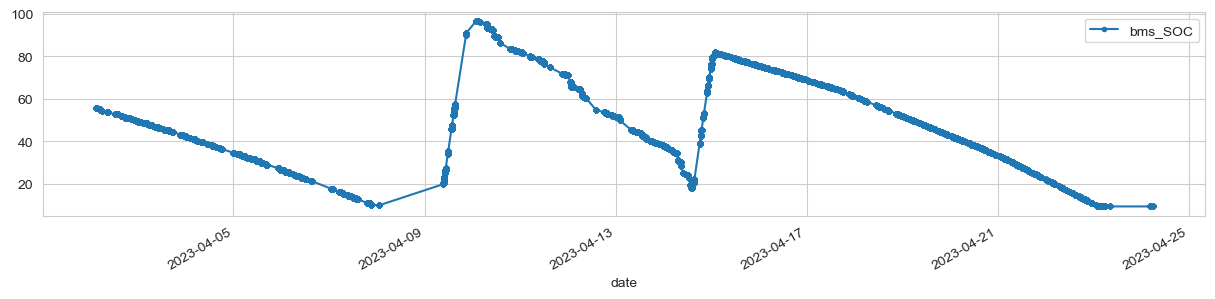

In [62]:
data07722= data_raw[data_raw.vin == 'LM8F7D896NA007722'].fillna(method='bfill').sort_values(by="collect_ts")
data07722 = data07722[(data07722["BCM_ebs_U_BATT"] > 3.) & (data07722["BCM_ebs_U_BATT"] < 18.)]
data07722_copy = data07722.copy()
data07722_copy['date'] = pd.to_datetime(data07722_copy["collect_ts"], unit='ms')
data07722_copy = data07722_copy.set_index("date")
data07722_copy["2023-04-01 18:00:00":"2023-04-25 22:00:00"][["BCM_ebs_U_BATT", "dcdc_realOutputVoltage"]].plot(grid=True, marker=".", figsize=(15, 3))
data07722_copy["2023-04-01 18:00:00":"2023-04-25 22:00:00"][["dcdc_realOutputCurrent"]].plot(grid=True, marker=".", figsize=(15, 3))
data07722_copy["2023-04-01 18:00:00":"2023-04-25 22:00:00"][["bms_SOC"]].plot(grid=True, marker=".", figsize=(15, 3))
plt.show()

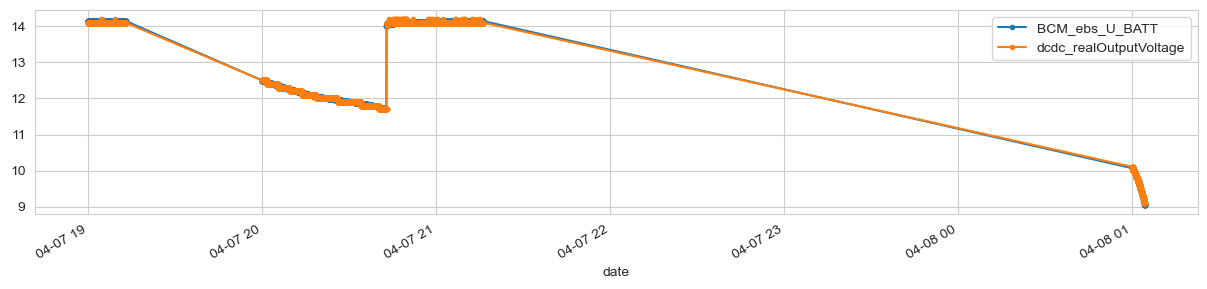

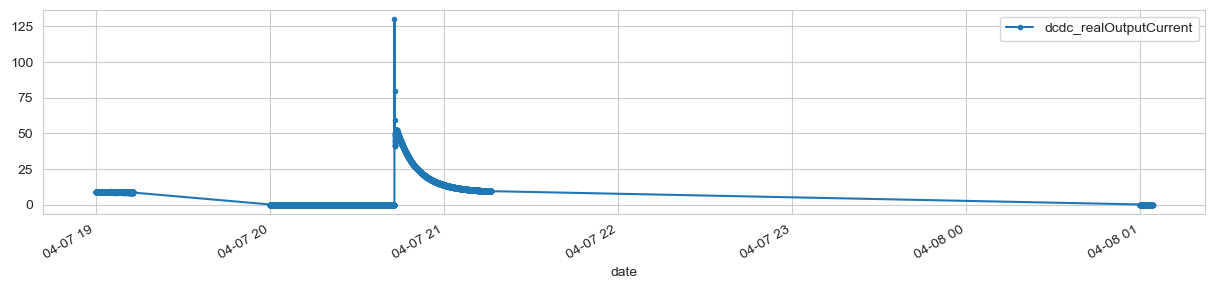

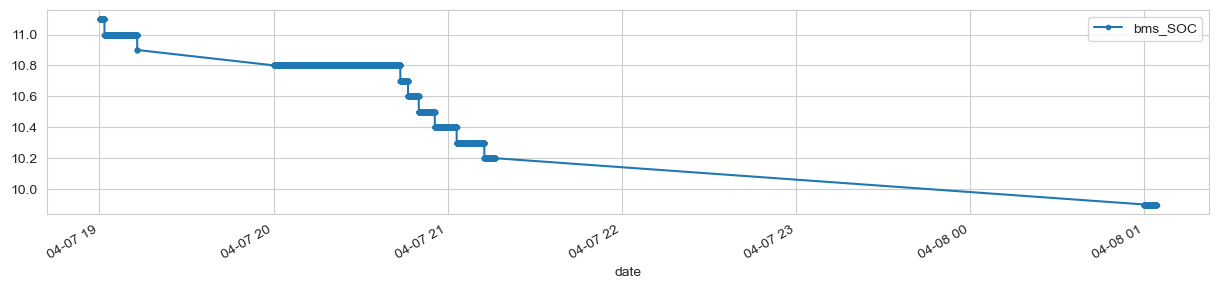

In [61]:
data07722_copy["2023-04-07 18:00:00":"2023-04-08 22:00:00"][["BCM_ebs_U_BATT", "dcdc_realOutputVoltage"]].plot(grid=True, marker=".", figsize=(15, 3))
data07722_copy["2023-04-07 18:00:00":"2023-04-08 22:00:00"][["dcdc_realOutputCurrent"]].plot(grid=True, marker=".", figsize=(15, 3))
data07722_copy["2023-04-07 18:00:00":"2023-04-08 22:00:00"][["bms_SOC"]].plot(grid=True, marker=".", figsize=(15, 3))

# extra code – saves the figure for the book
plt.show()

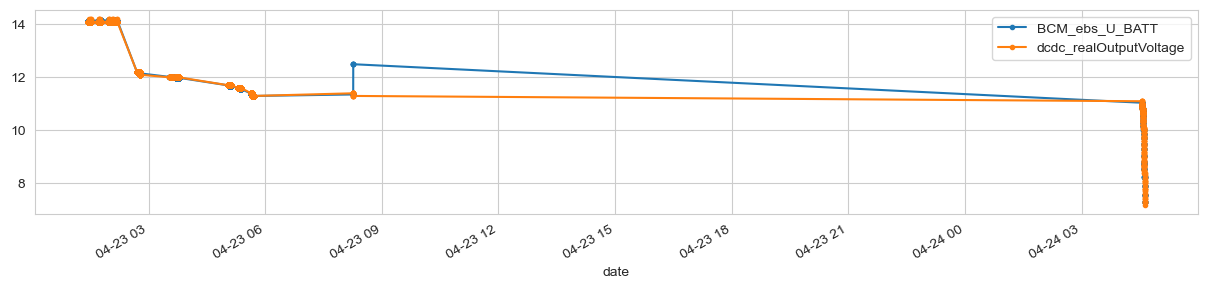

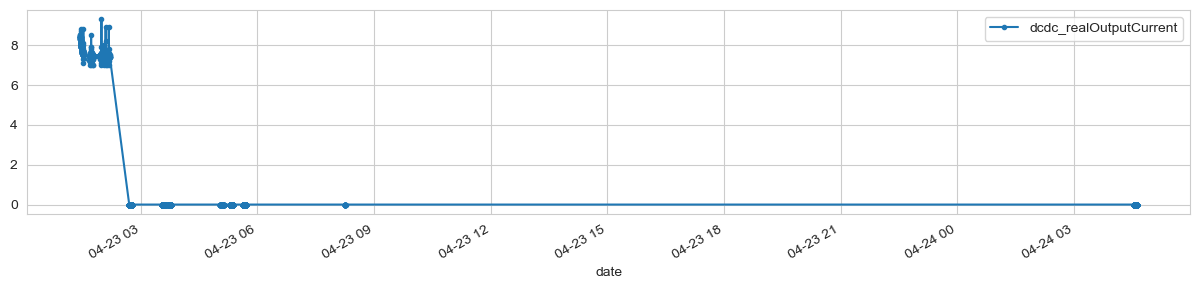

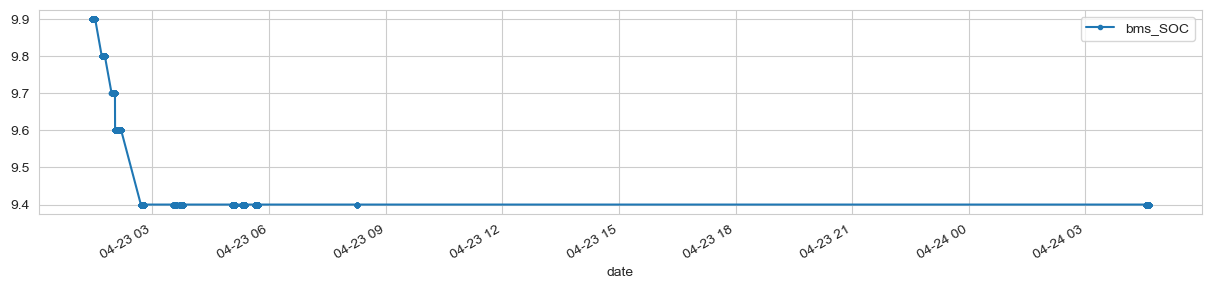

In [68]:
data07722_copy["2023-04-23 00:00:00":"2023-04-24 05:00:00"][["BCM_ebs_U_BATT", "dcdc_realOutputVoltage"]].plot(grid=True, marker=".", figsize=(15, 3))
data07722_copy["2023-04-23 00:00:00":"2023-04-24 05:00:00"][["dcdc_realOutputCurrent"]].plot(grid=True, marker=".", figsize=(15, 3))
data07722_copy["2023-04-23 00:00:00":"2023-04-24 05:00:00"][["bms_SOC"]].plot(grid=True, marker=".", figsize=(15, 3))

# extra code – saves the figure for the book
plt.show()

## 10 LM8F7D893NA002400 原因不明，突然降低


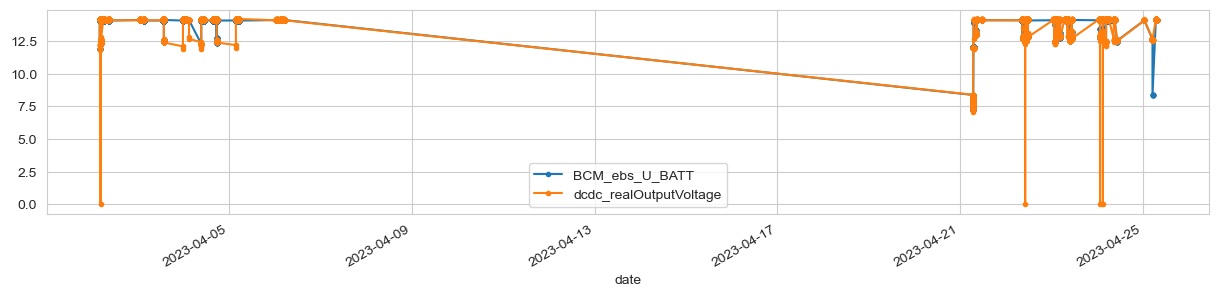

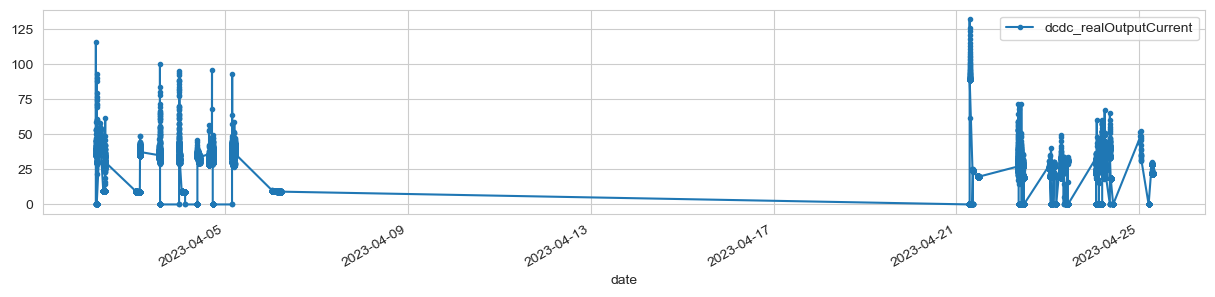

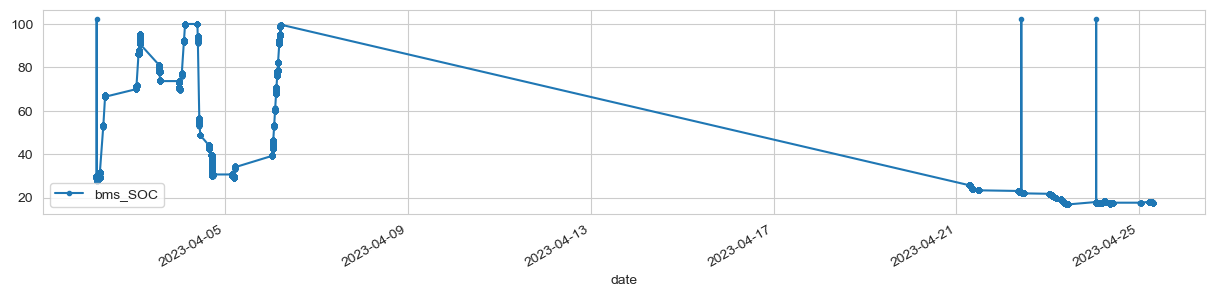

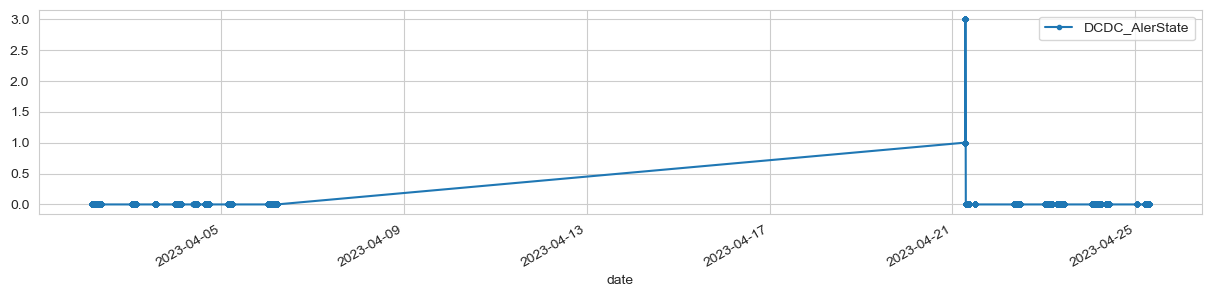

In [70]:
data02400= data_raw[data_raw.vin == 'LM8F7D893NA002400'].fillna(method='bfill').sort_values(by="collect_ts")
data02400 = data02400[(data02400["BCM_ebs_U_BATT"] > 3.) & (data02400["BCM_ebs_U_BATT"] < 18.)]
data02400_copy = data02400.copy()
data02400_copy['date'] = pd.to_datetime(data02400_copy["collect_ts"], unit='ms')
data02400_copy = data02400_copy.set_index("date")
data02400_copy["2023-04-01 18:00:00":"2023-04-25 22:00:00"][["BCM_ebs_U_BATT", "dcdc_realOutputVoltage"]].plot(grid=True, marker=".", figsize=(15, 3))
data02400_copy["2023-04-01 18:00:00":"2023-04-25 22:00:00"][["dcdc_realOutputCurrent"]].plot(grid=True, marker=".", figsize=(15, 3))
data02400_copy["2023-04-01 18:00:00":"2023-04-25 22:00:00"][["bms_SOC"]].plot(grid=True, marker=".", figsize=(15, 3))
data02400_copy["2023-04-01 18:00:00":"2023-04-25 22:00:00"][["DCDC_AlerState"]].plot(grid=True, marker=".", figsize=(15, 3))
plt.show()

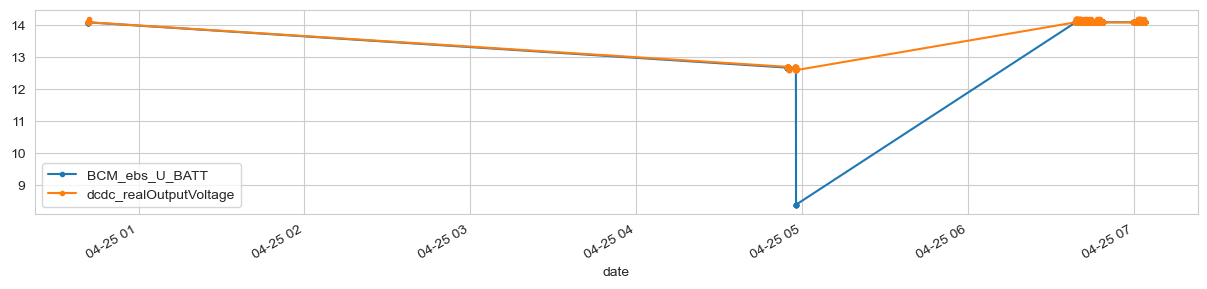

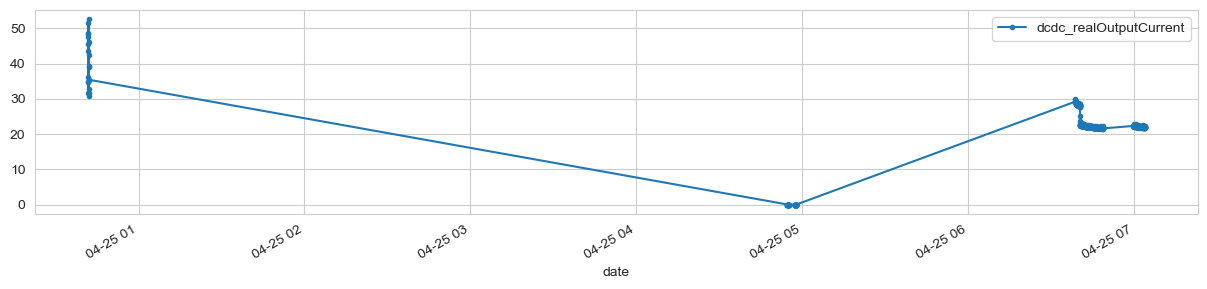

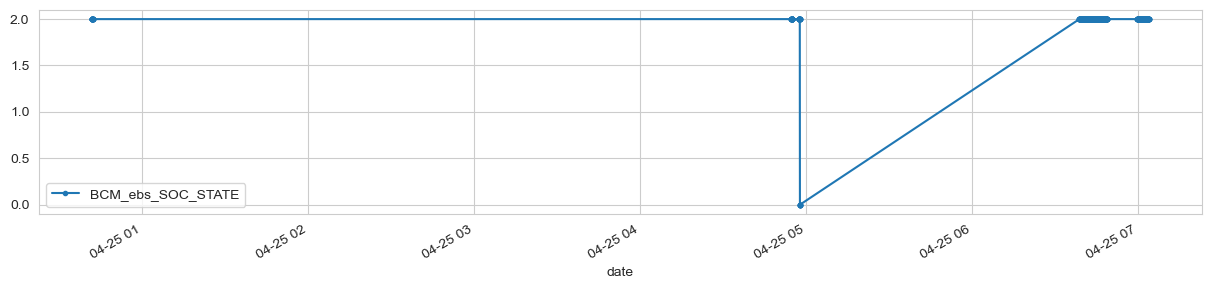

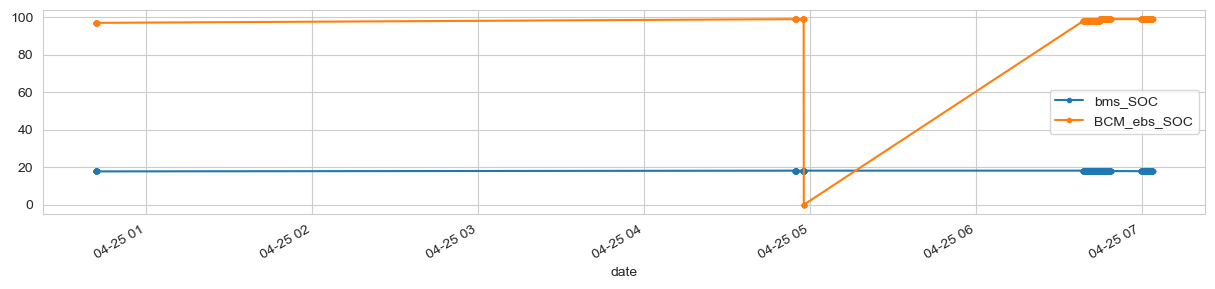

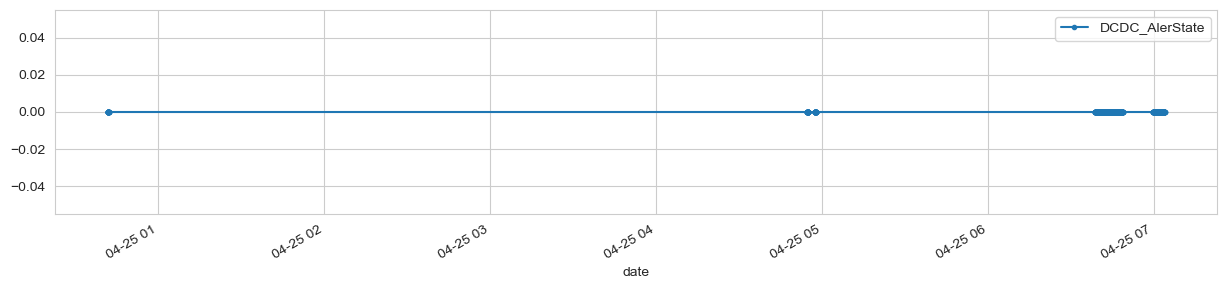

In [74]:
data02400_copy["2023-04-25 00:00:00":"2023-04-25 22:00:00"][["BCM_ebs_U_BATT", "dcdc_realOutputVoltage"]].plot(grid=True, marker=".", figsize=(15, 3))
data02400_copy["2023-04-25 00:00:00":"2023-04-25 22:00:00"][["dcdc_realOutputCurrent"]].plot(grid=True, marker=".", figsize=(15, 3))
data02400_copy["2023-04-25 00:00:00":"2023-04-25 22:00:00"][["BCM_ebs_SOC_STATE"]].plot(grid=True, marker=".", figsize=(15, 3))
data02400_copy["2023-04-25 00:00:00":"2023-04-25 22:00:00"][["bms_SOC", "BCM_ebs_SOC"]].plot(grid=True, marker=".", figsize=(15, 3))
data02400_copy["2023-04-25 00:00:00":"2023-04-25 22:00:00"][["DCDC_AlerState"]].plot(grid=True, marker=".", figsize=(15, 3))
plt.show()

## 11 LM8F7D797NA030721 dcdc故障

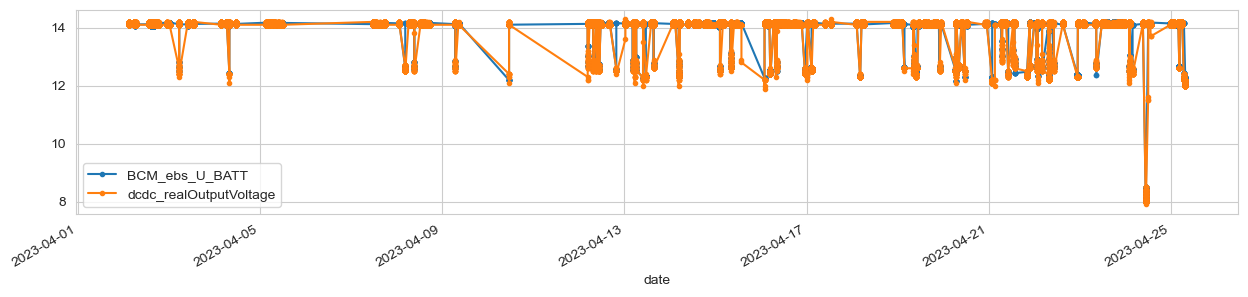

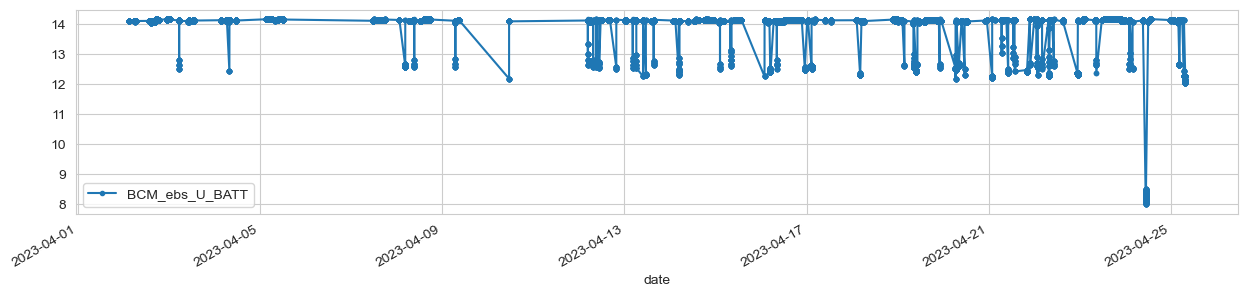

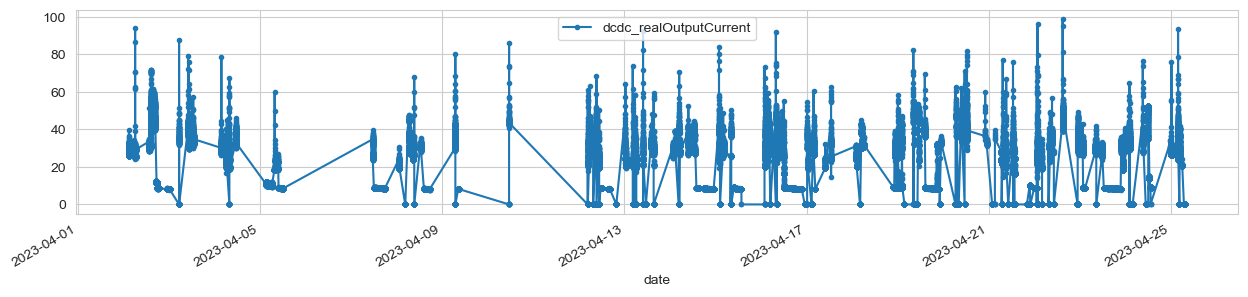

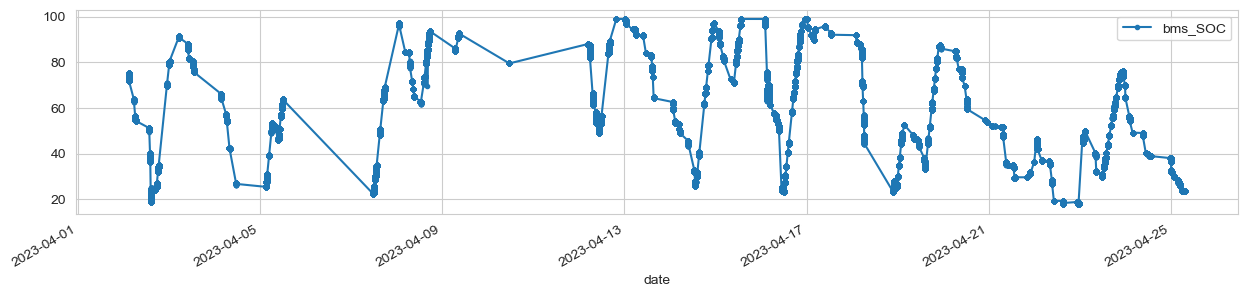

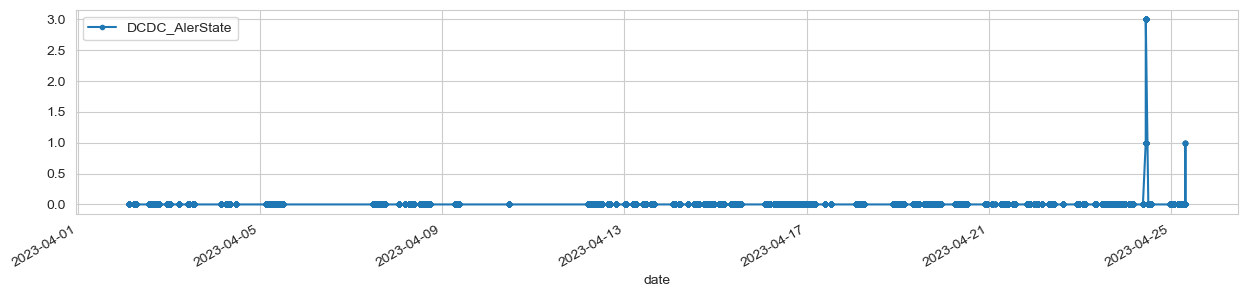

In [83]:
data30721= data_raw[data_raw.vin == 'LM8F7D797NA030721'].fillna(method='bfill').sort_values(by="collect_ts")
data30721 = data30721[(data30721["BCM_ebs_U_BATT"] > 3.) & (data30721["BCM_ebs_U_BATT"] < 18.)]
data30721_copy = data30721.copy()
data30721_copy['date'] = pd.to_datetime(data30721_copy["collect_ts"], unit='ms')
data30721_copy = data30721_copy.set_index("date")
data30721_copy["2023-04-01 18:00:00":"2023-04-25 22:00:00"][["BCM_ebs_U_BATT", "dcdc_realOutputVoltage"]].plot(grid=True, marker=".", figsize=(15, 3))
data30721_copy["2023-04-01 18:00:00":"2023-04-25 22:00:00"][["BCM_ebs_U_BATT"]].plot(grid=True, marker=".", figsize=(15, 3))
data30721_copy["2023-04-01 18:00:00":"2023-04-25 22:00:00"][["dcdc_realOutputCurrent"]].plot(grid=True, marker=".", figsize=(15, 3))
data30721_copy["2023-04-01 18:00:00":"2023-04-25 22:00:00"][["bms_SOC"]].plot(grid=True, marker=".", figsize=(15, 3))
data30721_copy["2023-04-01 18:00:00":"2023-04-25 22:00:00"][["DCDC_AlerState"]].plot(grid=True, marker=".", figsize=(15, 3))
plt.show()

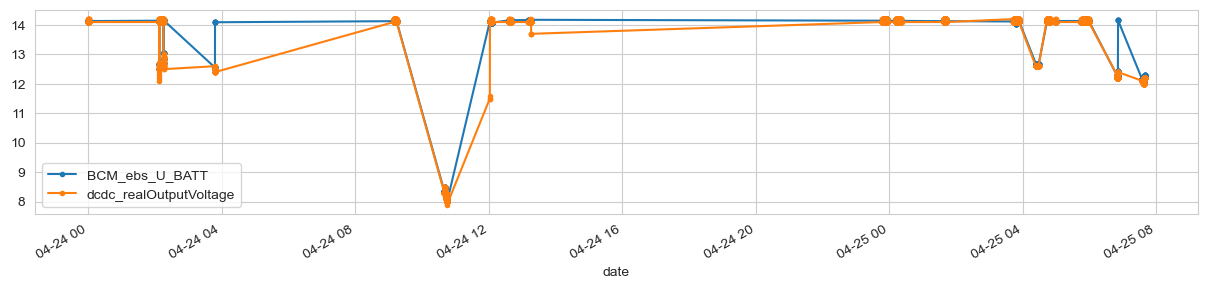

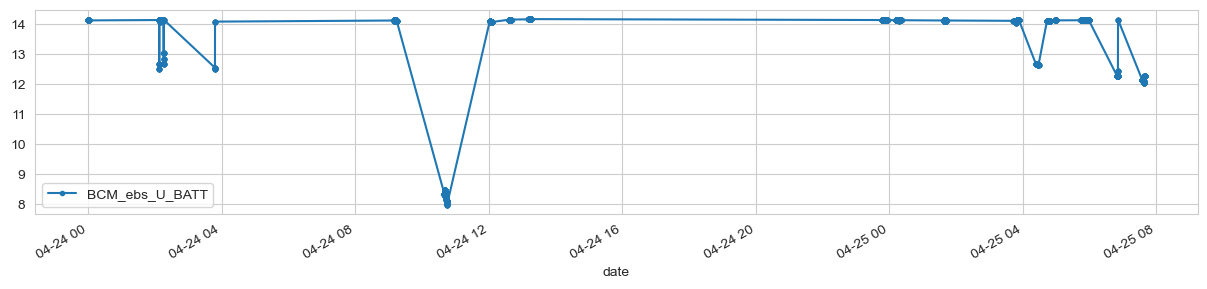

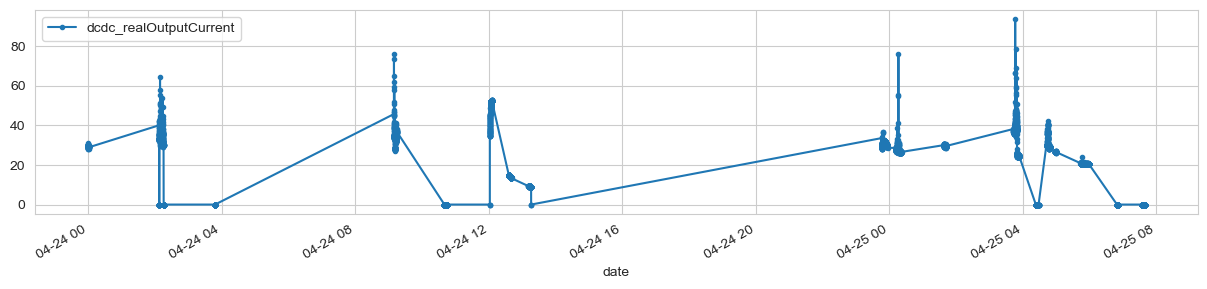

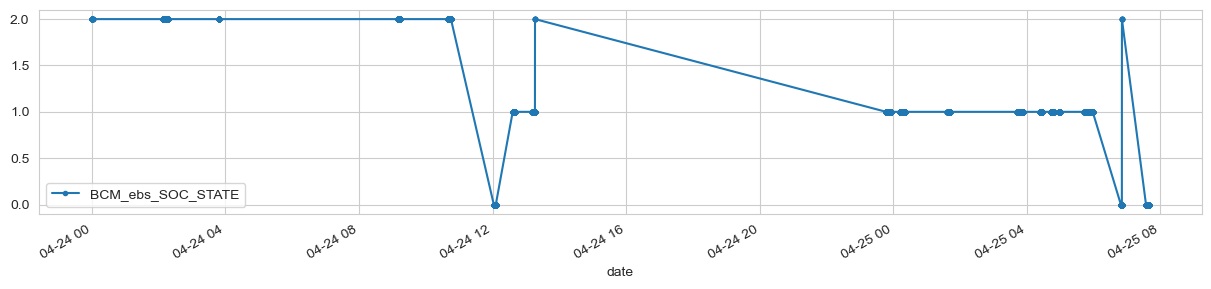

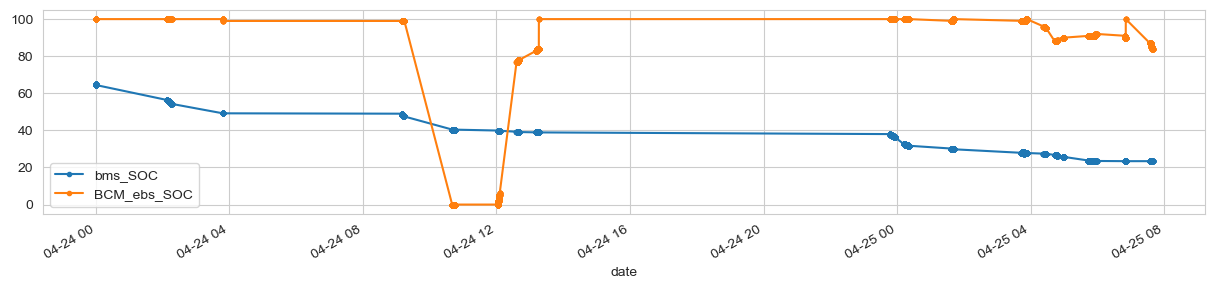

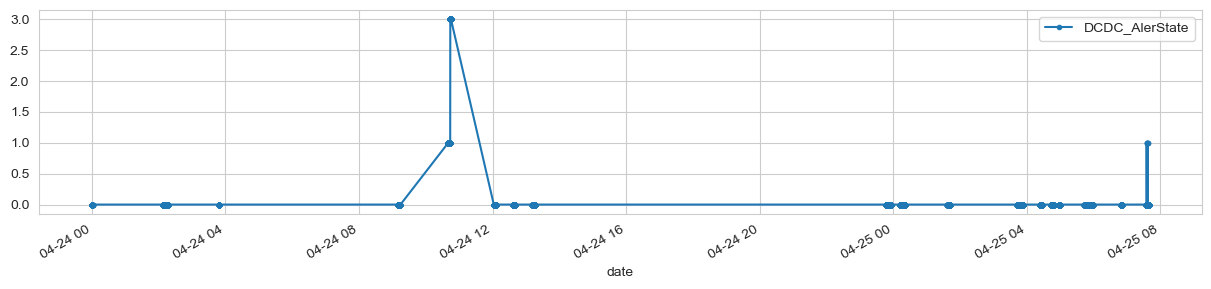

In [87]:
data30721_copy["2023-04-24 00:00:00":"2023-04-25 22:00:00"][["BCM_ebs_U_BATT", "dcdc_realOutputVoltage"]].plot(grid=True, marker=".", figsize=(15, 3))
data30721_copy["2023-04-24 00:00:00":"2023-04-25 22:00:00"][["BCM_ebs_U_BATT"]].plot(grid=True, marker=".", figsize=(15, 3))
data30721_copy["2023-04-24 00:00:00":"2023-04-25 22:00:00"][["dcdc_realOutputCurrent"]].plot(grid=True, marker=".", figsize=(15, 3))
data30721_copy["2023-04-24 00:00:00":"2023-04-25 22:00:00"][["BCM_ebs_SOC_STATE"]].plot(grid=True, marker=".", figsize=(15, 3))
data30721_copy["2023-04-24 00:00:00":"2023-04-25 22:00:00"][["bms_SOC", "BCM_ebs_SOC"]].plot(grid=True, marker=".", figsize=(15, 3))
data30721_copy["2023-04-24 00:00:00":"2023-04-25 22:00:00"][["DCDC_AlerState"]].plot(grid=True, marker=".", figsize=(15, 3))
plt.show()

## 12 LM8F7D897NA000312 dcdc故障，疑似电池故障

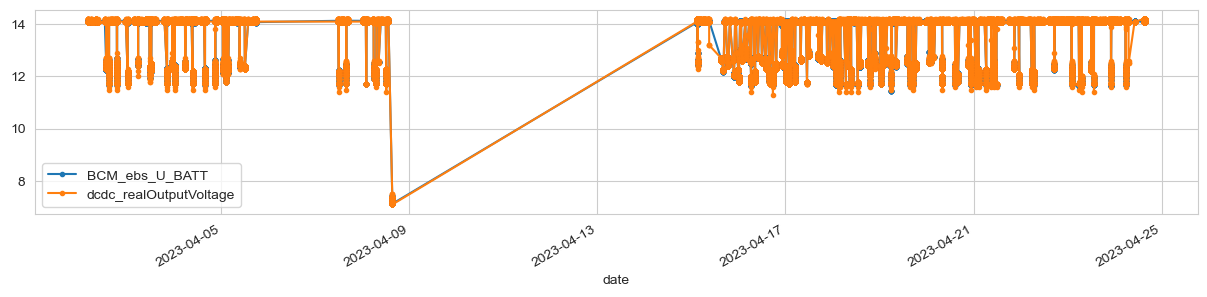

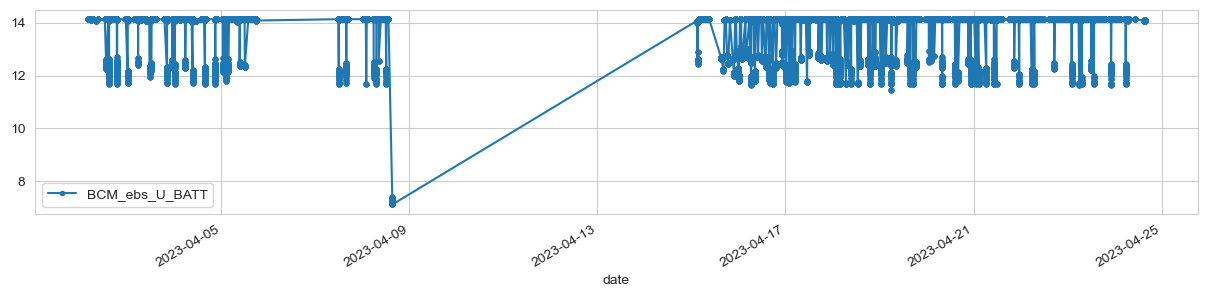

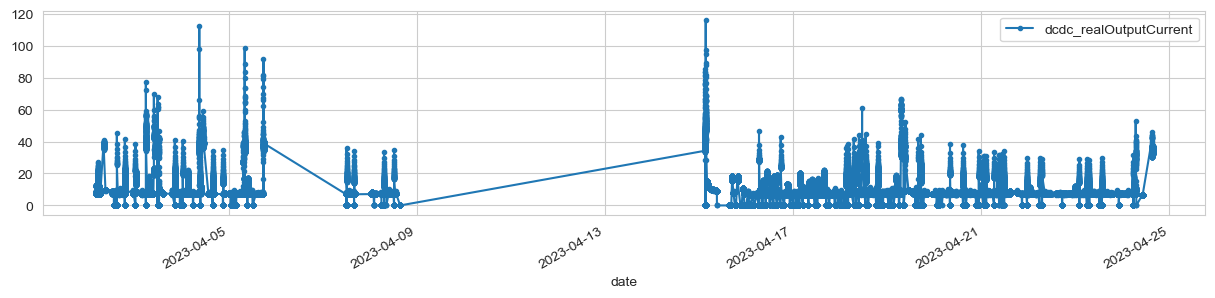

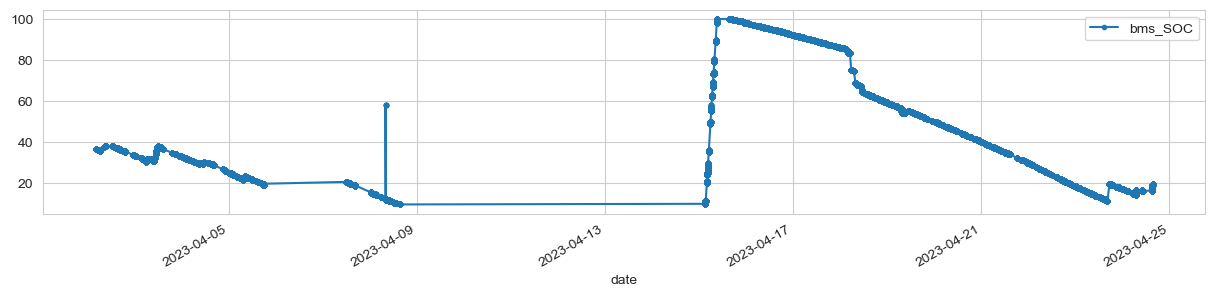

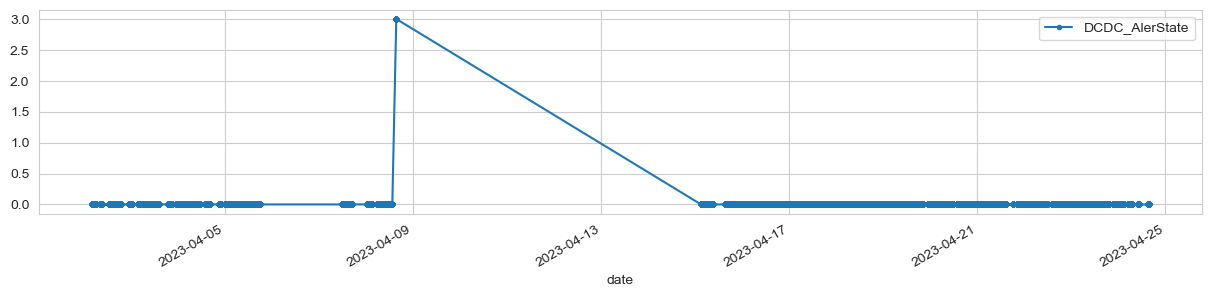

In [86]:
data00312= data_raw[data_raw.vin == 'LM8F7D897NA000312'].fillna(method='bfill').sort_values(by="collect_ts")
data00312 = data00312[(data00312["BCM_ebs_U_BATT"] > 3.) & (data00312["BCM_ebs_U_BATT"] < 18.)]
data00312_copy = data00312.copy()
data00312_copy['date'] = pd.to_datetime(data00312_copy["collect_ts"], unit='ms')
data00312_copy = data00312_copy.set_index("date")
data00312_copy["2023-04-01 18:00:00":"2023-04-25 22:00:00"][["BCM_ebs_U_BATT", "dcdc_realOutputVoltage"]].plot(grid=True, marker=".", figsize=(15, 3))
data00312_copy["2023-04-01 18:00:00":"2023-04-25 22:00:00"][["BCM_ebs_U_BATT"]].plot(grid=True, marker=".", figsize=(15, 3))
data00312_copy["2023-04-01 18:00:00":"2023-04-25 22:00:00"][["dcdc_realOutputCurrent"]].plot(grid=True, marker=".", figsize=(15, 3))
data00312_copy["2023-04-01 18:00:00":"2023-04-25 22:00:00"][["bms_SOC"]].plot(grid=True, marker=".", figsize=(15, 3))
data00312_copy["2023-04-01 18:00:00":"2023-04-25 22:00:00"][["DCDC_AlerState"]].plot(grid=True, marker=".", figsize=(15, 3))
plt.show()

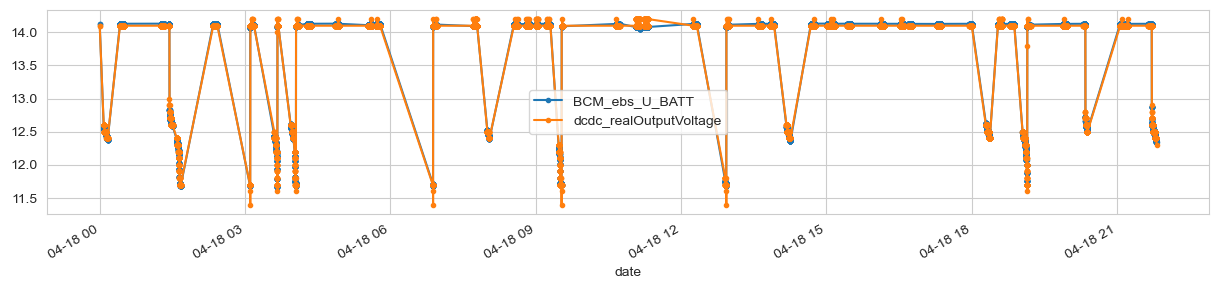

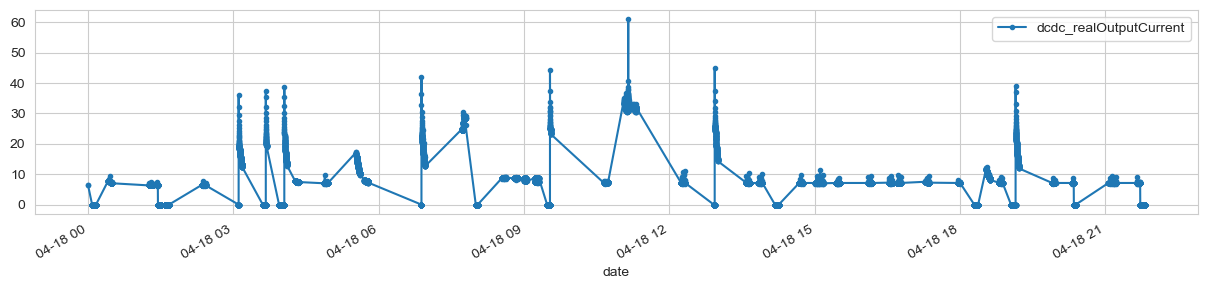

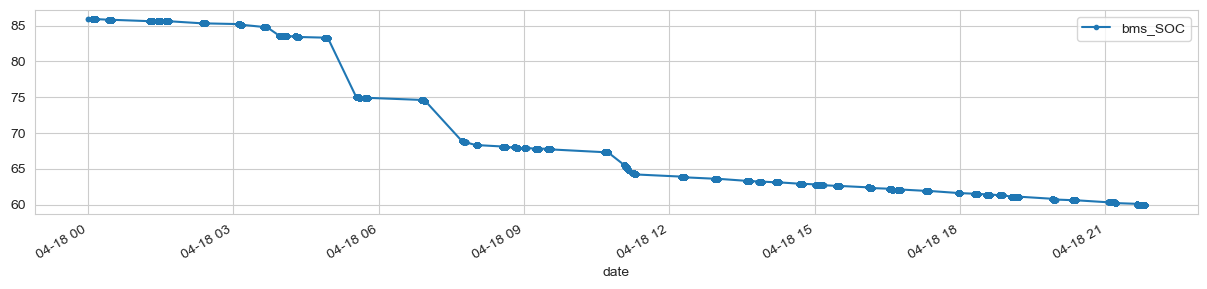

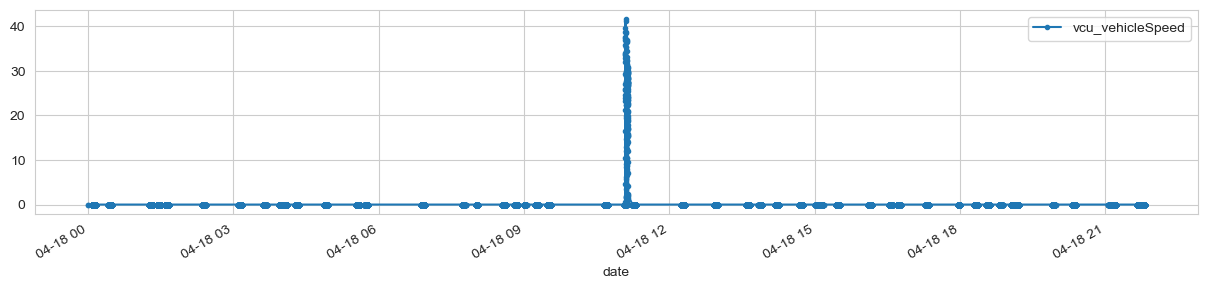

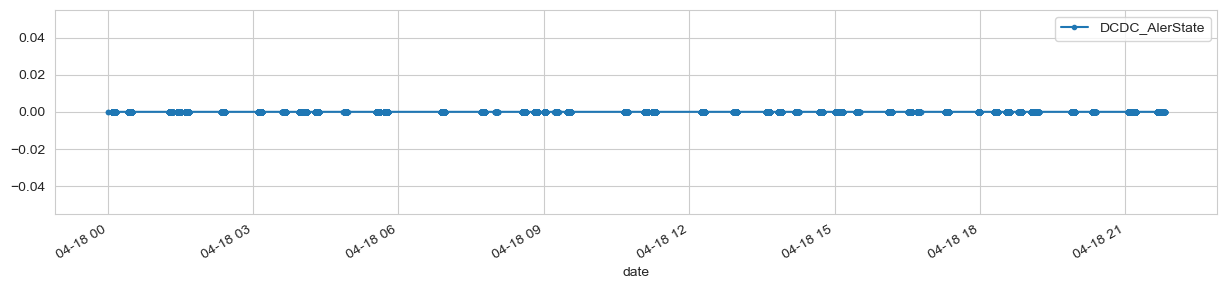

In [93]:
data00312_copy["2023-04-18 00:00:00":"2023-04-18 22:00:00"][["BCM_ebs_U_BATT", "dcdc_realOutputVoltage"]].plot(grid=True, marker=".", figsize=(15, 3))
# data00312_copy["2023-04-18 00:00:00":"2023-04-18 22:00:00"][["BCM_ebs_SOC"]].plot(grid=True, marker=".", figsize=(15, 3))
data00312_copy["2023-04-18 00:00:00":"2023-04-18 22:00:00"][["dcdc_realOutputCurrent"]].plot(grid=True, marker=".", figsize=(15, 3))
data00312_copy["2023-04-18 00:00:00":"2023-04-18 22:00:00"][["bms_SOC"]].plot(grid=True, marker=".", figsize=(15, 3))
data00312_copy["2023-04-18 00:00:00":"2023-04-18 22:00:00"][["vcu_vehicleSpeed"]].plot(grid=True, marker=".", figsize=(15, 3))
data00312_copy["2023-04-18 00:00:00":"2023-04-18 22:00:00"][["DCDC_AlerState"]].plot(grid=True, marker=".", figsize=(15, 3))
plt.show()

In [ ]:
import seaborn as sns

sns.distplot(data_raw[data_raw.dcdc_realOutputVoltage < 11.].dcdc_realOutputVoltage, hist=True, kde=False)

In [ ]:
pd.DataFrame(data_raw[data_raw.BCM_ebs_U_BATT > 14.25].BCM_ebs_U_BATT.value_counts()).sort_values(by='BCM_ebs_U_BATT')

In [ ]:
import seaborn as sns

sns.distplot(data_raw[data_raw.BCM_ebs_U_BATT > 14.252].BCM_ebs_U_BATT, hist=True, kde=False)

In [ ]:
data_raw.describe()

In [ ]:
pd.DataFrame(data_raw["BCM_ebs_U_BATT"].value_counts()).sort_values(by='BCM_ebs_U_BATT')

In [ ]:
# 清除异常数据之后的数据
data_raw = data_raw.fillna(method='ffill')
data = data_raw[(data_raw.BCM_ebs_U_BATT > 3.) & (data_raw.BCM_ebs_U_BATT < 18.)
                & (data_raw.BCM_ebs_SOC <= 100.)
                & (data_raw.bms_pLimitDrive <= 400.)
                ]
data.info()

In [ ]:
data["vin"].value_counts()

In [ ]:
data.info()

In [ ]:
import matplotlib.pyplot as plt

data.BCM_ebs_U_BATT.hist(bins=10, figsize=(15, 3))
plt.show()

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["BCM_ebs_U_BATT", "BCM_ebs_SOC"]
scatter_matrix(data[attributes], figsize=(8, 8))

In [ ]:
data[(data.bms_SOC >= 30.) & (data.BCM_ebs_U_BATT < 10.5)]["vin"].value_counts()

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["BCM_ebs_U_BATT", "BCM_ebs_SOC"]
scatter_matrix(data[data["vin"] == "LM8F7D895NA004066"][attributes], figsize=(8, 8))

In [ ]:


attributes = ["BCM_ebs_U_BATT", "DCDC_AlerState"]
scatter_matrix(data[attributes], figsize=(8, 8))

In [ ]:
data.BCM_ebs_U_BATT.describe()

In [ ]:
import seaborn as sns

sns.distplot(data.bms_SOC, hist=True, kde=True)

In [ ]:
import seaborn as sns

sns.distplot(data[data.BCM_ebs_U_BATT > 10.0].BCM_ebs_U_BATT, hist=True, kde=True)